In [15]:
import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model, Model, save_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv3D, Conv2D, Conv1D, Dropout, MaxPooling2D, LeakyReLU, BatchNormalization, Reshape, InputLayer, Input, ZeroPadding3D, ZeroPadding2D, UpSampling2D, UpSampling3D, MaxPool3D, MaxPooling3D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from matplotlib import pyplot
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import sys

NUM_FRAMES = 10
RESOLUTION = 32
CHANNELS = 1

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

In [16]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [17]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image

def load_dataset():    
    # Download and load the dataset.
    fpath = keras.utils.get_file(
        "moving_mnist.npy",
        "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
    )
    dataset = np.load(fpath)    
    dataset = np.swapaxes(dataset, 0, 1)
    dataset = np.expand_dims(dataset, 4)    
    dataset = dataset[:, :, ::2, ::2, :]  
    return dataset

dataset_20 = load_dataset()
dataset0 = dataset_20[:, :10, ...]
dataset1 = dataset_20[:, 10:, ...]
print(dataset0.shape)
dataset = np.concatenate((dataset0, dataset1))
print(dataset.shape)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.seed(42)
np.random.shuffle(indexes)
train_index = indexes[: int(0.8 * dataset.shape[0])]
val_index = indexes[int(0.8 * dataset.shape[0]) : int(0.95 * dataset.shape[0])]
test_index = indexes[int(0.95 * dataset.shape[0]) :]

train_dataset = dataset[train_index] / 255.
val_dataset = dataset[val_index] / 255.
test_dataset = dataset[test_index] / 255.
print(train_dataset.shape)

(10000, 10, 32, 32, 1)
(20000, 10, 32, 32, 1)
(16000, 10, 32, 32, 1)


In [18]:
x_train = np.array(train_dataset[:, :, :, :, :])
x_train[:, 1:9, :, :, :] = 0
y_train = train_dataset[:, :, :, :, :]
x_val = np.array(val_dataset[:, :, :, :, :])
x_val[:, 1:9, :, :, :] = 0
y_val = val_dataset[:, :, :, :, :]

size = x_train.nbytes + y_train.nbytes + x_val.nbytes + y_val.nbytes
print(f"Size arrays: {size * 1e-9} GB")

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"x_val: {x_val.shape}")
print(f"y_val: {y_val.shape}")

Size arrays: 3.11296 GB
x_train: (16000, 10, 32, 32, 1)
y_train: (16000, 10, 32, 32, 1)
x_val: (3000, 10, 32, 32, 1)
y_val: (3000, 10, 32, 32, 1)


In [19]:
def flatten_animation(og_animation):    
    original_shape = og_animation.shape
    flat = original_shape[2] * original_shape[3] * original_shape[4]
    flat_animation = og_animation.flatten()
    flat_animation = flat_animation.reshape((original_shape[0], original_shape[1], flat))
    return flat_animation, original_shape
    
def reconstruct_animation(flat_animation, original_shape):    
    rec_animation = flat_animation.reshape(original_shape)
    return rec_animation 

x_train, x_train_shape = flatten_animation(x_train)
y_train, y_train_shape = flatten_animation(y_train)
x_val, x_val_shape = flatten_animation(x_val)
y_val, y_val_shape = flatten_animation(y_val)
print(x_train_shape)

(16000, 10, 32, 32, 1)


In [20]:
import gc

del dataset
del train_dataset
del val_dataset

gc.collect()

536141

In [21]:
def display_img(img):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))        
    ax.imshow(img, cmap='gray')

def display_seq(data, label=''):
    fig, axes = plt.subplots(1, 10, figsize=(25, 5))
    ax = axes.flatten()    
    for i, frame in enumerate(data): 
        if i >= 10:
            break
        ax[i].set_title(f"{label} {i}", fontsize=32)
        ax[i].imshow(frame, cmap='gray', vmin=0., vmax=1.)            
        ax[i].axis("off")

In [22]:
img_shape = x_train[0].shape
print(img_shape)
def create_model():
    model = Sequential()    
    model.add(InputLayer(input_shape=img_shape, name='Input_1'))
    model.add(layers.SimpleRNN(img_shape[1], return_sequences=True, activation='tanh'))
    model.add(layers.SimpleRNN(img_shape[1], return_sequences=True, activation='tanh'))
    model.add(layers.SimpleRNN(img_shape[1], return_sequences=True, activation='tanh'))

    model.compile(optimizer='adam', loss='mse')
    return model

(10, 1024)


In [23]:
## Model Training
#With our model and data constructed, we can now train the model.
import time
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pickle

start_time = time.time()
# Define some callbacks to improve training.
checkpoint_filepath = './savedModels/03_Simple_RNN_v01_nonRecursive_REAL_RESULTS_02.h5'
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_loss", save_best_only=True)

print(x_train.shape)
# Fit the model to the training data.
model = create_model()
model.fit(x_train,y_train,batch_size=128,epochs=500,validation_data=(x_val, y_val),callbacks=[early_stopping, reduce_lr, model_checkpoint])

print("--- %s seconds ---" % (time.time() - start_time))

(16000, 10, 1024)
Epoch 1/500
125/125 [==============================] - 3s 21ms/step - loss: 0.0444 - val_loss: 0.0321 - lr: 0.0010
Epoch 2/500
125/125 [==============================] - 2s 18ms/step - loss: 0.0312 - val_loss: 0.0306 - lr: 0.0010
Epoch 3/500
125/125 [==============================] - 2s 18ms/step - loss: 0.0300 - val_loss: 0.0299 - lr: 0.0010
Epoch 4/500
125/125 [==============================] - 2s 18ms/step - loss: 0.0294 - val_loss: 0.0295 - lr: 0.0010
Epoch 5/500
125/125 [==============================] - 2s 17ms/step - loss: 0.0290 - val_loss: 0.0293 - lr: 0.0010
Epoch 6/500
125/125 [==============================] - 2s 17ms/step - loss: 0.0287 - val_loss: 0.0290 - lr: 0.0010
Epoch 7/500
125/125 [==============================] - 2s 18ms/step - loss: 0.0285 - val_loss: 0.0288 - lr: 0.0010
Epoch 8/500
125/125 [==============================] - 2s 18ms/step - loss: 0.0283 - val_loss: 0.0287 - lr: 0.0010
Epoch 9/500
125/125 [==============================] - 2s 18ms

In [24]:
# Clamp images, else the predictions get very blurry
# theta: threshold to decide where to clip values
# epsilon: keep some values unclipped, to avoid too jagged edges
def clamp_image_array(y_hat, theta=.3, epsilon=.1):        
    y_hat_p = np.where(y_hat < theta - epsilon, 0, y_hat)
    y_hat_p = np.where(y_hat_p >= theta + epsilon, 1, y_hat_p)
    return y_hat_p

/tmp/ipykernel_8827/1656071344.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 10, figsize=(25, 5))


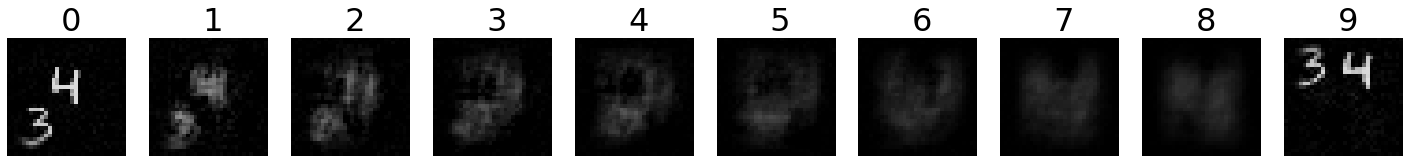

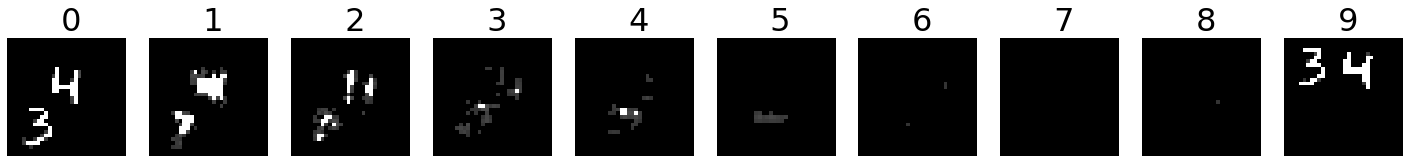

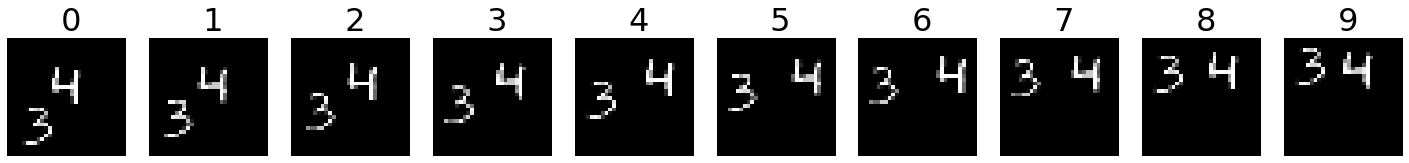

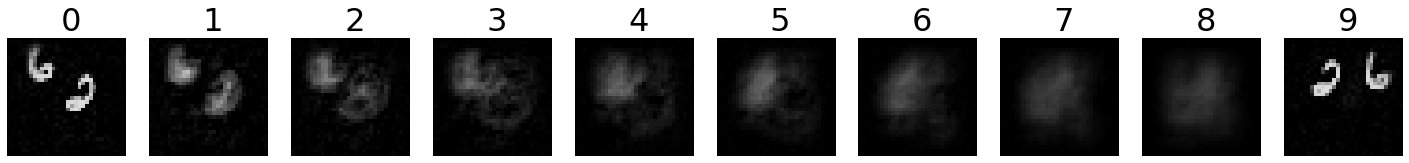

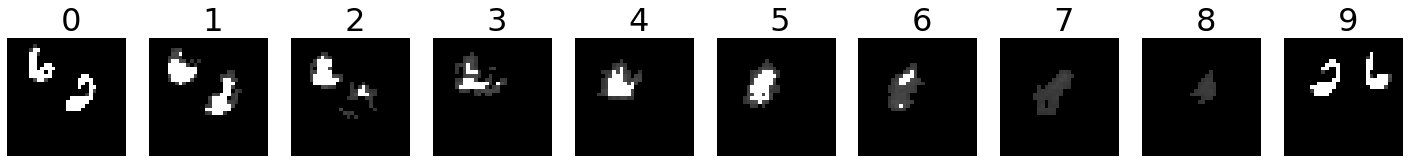

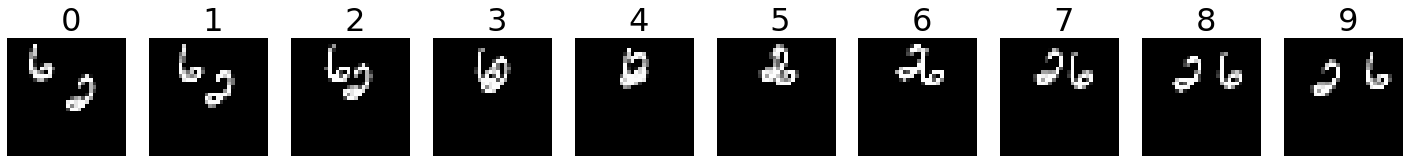

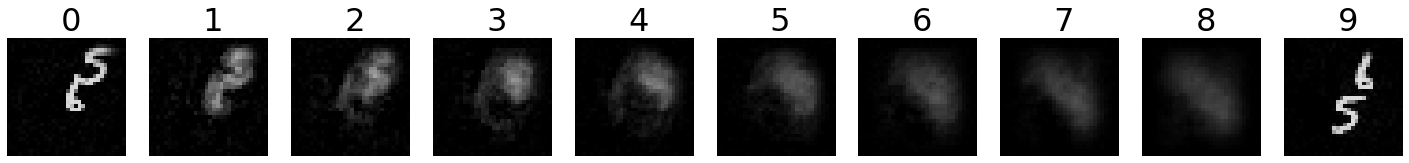

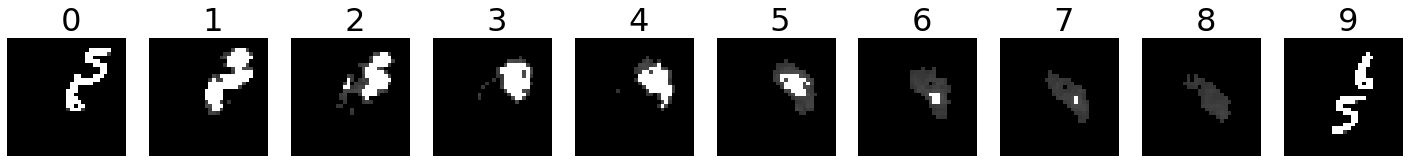

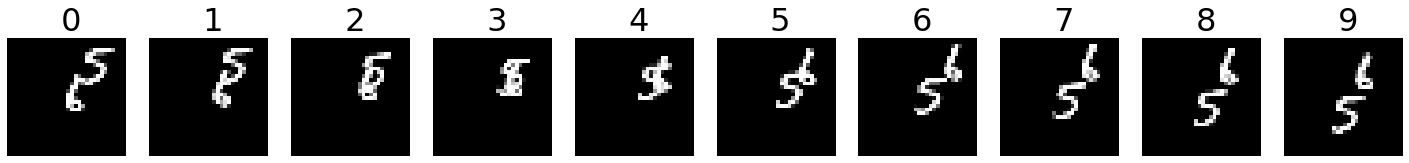

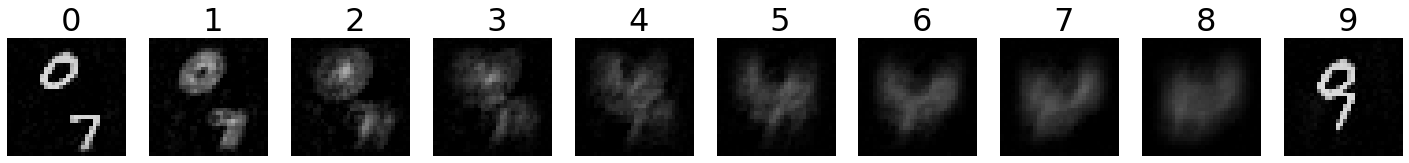

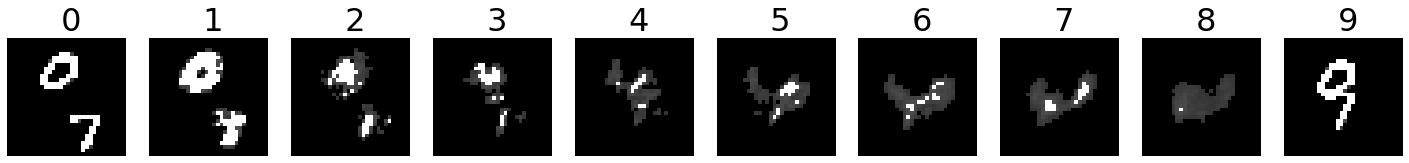

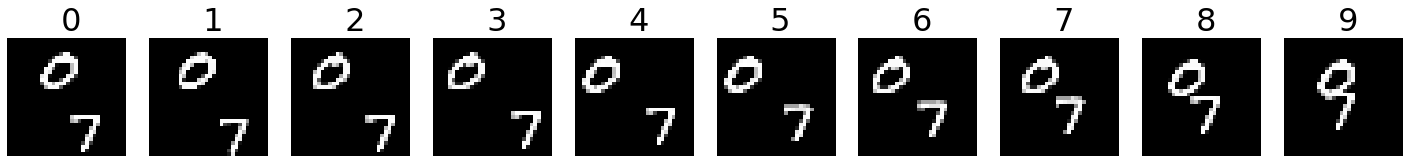

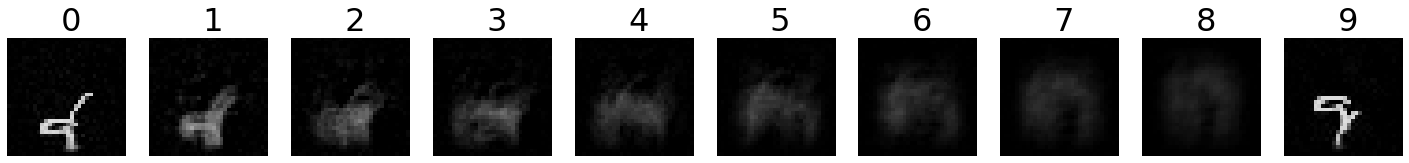

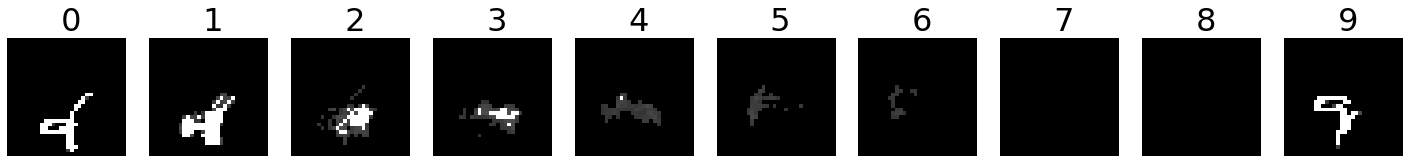

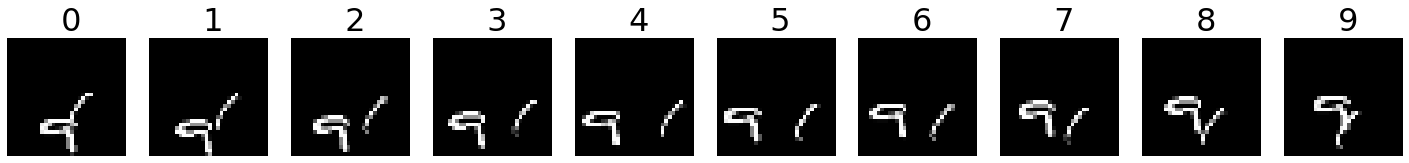

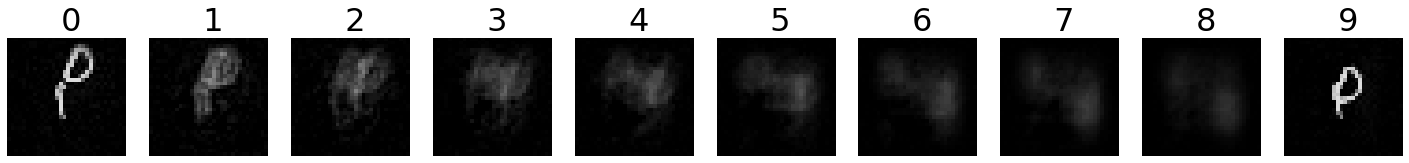

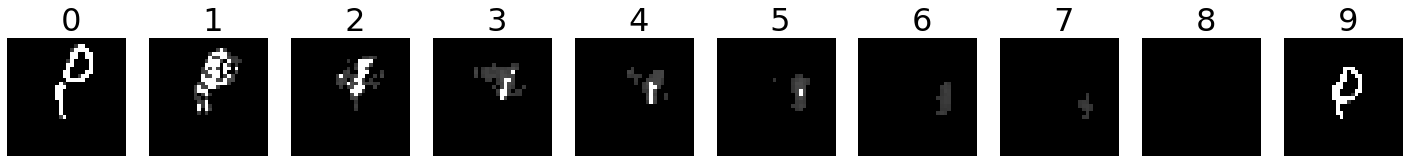

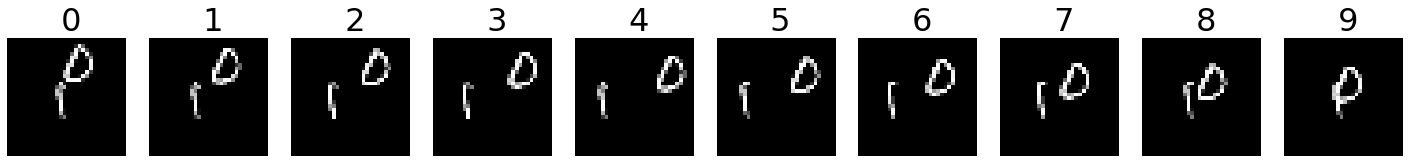

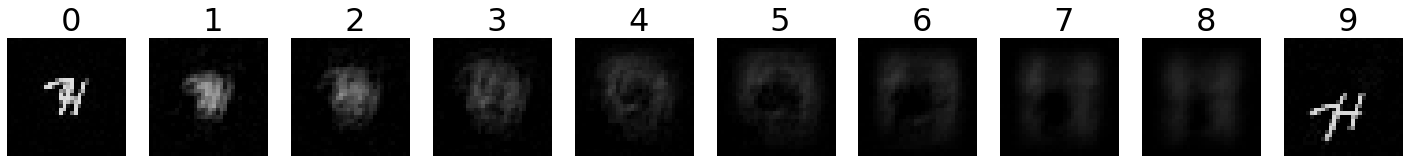

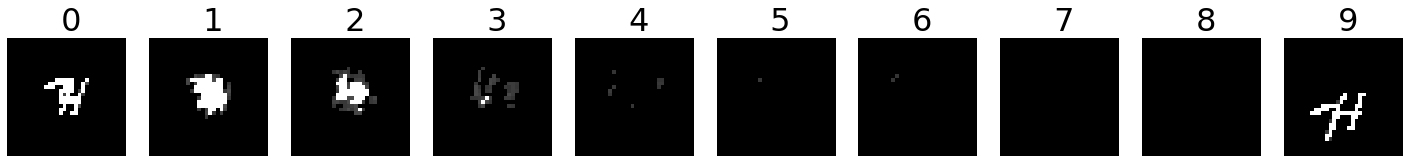

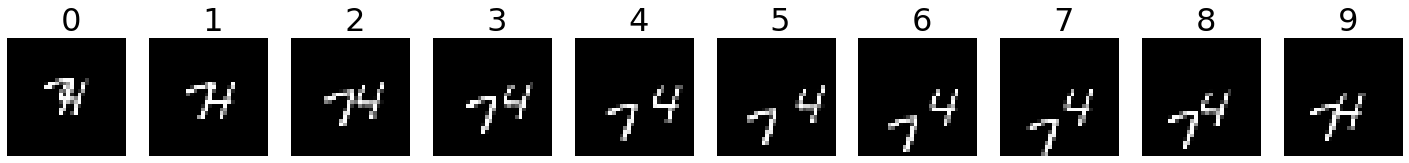

In [25]:
model = keras.models.load_model(checkpoint_filepath)

good = [22, 44, 52, 64, 73, 76, 94]
for i in good:
    test_set = np.array(test_dataset[i, :, :, :, :])
    test_set = np.expand_dims(test_set, axis=0)
    y_test_set = np.array(test_set)
    x_test_set = test_set
    x_test_set[:, 1:9, :, :, :] = 0       
    
    yhat = model.predict(flatten_animation(x_test_set)[0])
    yhat = reconstruct_animation(yhat, y_test_set.shape)

    display_seq(yhat[0])
    display_seq(clamp_image_array(yhat[0], theta=.25, epsilon=0.05))    
    display_seq(y_test_set[0])